# Práctico 3: Regresión

## Objetivos del trabajo
* Objetivo general:
    - Introducir la técnica de regresión
* Objetivos específicos:
    - Continuar el estudio del dataset de la ECH, en este caso con una variable de respuesta continua
    - Aplicar herramientas de análisis estadístico descriptivo adecuadas al caso
    - Aplicar la técnica de regresión
    - Proponer alternativas de tratamiento de datos para resolver problemas de la aplicación de la técnica de regresión

## Presentación del caso de estudio
* Predicción del ingreso de las personas:
    - Queremos desarrollar un modelo de predicción de los ingresos de las porsonas por trabajo en relación de dependencia, a partir de los datos de la ECH

1. Objetivo:
    * **Tarea (T)**: Predicción del ingreso de las personas por su trabajo en relación de dependencia, a partir de los datos de la ECH 
    * **Entrenamiento (E)**: Utilizamos los datos de la Encuesta Continua de Hogares del INE (ECH) de 2017        
    * **Performance (P)**: Buscamos minimizar el error de predicción definido como MSE (error cuadrático medio)
2. Links de referencia:
    * [Encuesta Continua de Hogares 2017](https://anterior.ine.gub.uy/web/guest/encuesta-continua-de-hogares1) 
    * Datos a utilizar: [Bases ECH 2017 en formato sav](https://anterior.ine.gub.uy/c/document_library/get_file?uuid=e38ea53c-7253-4007-9f67-2f5f161eea91&groupId=10181)
    * [Diccionario de variables ECH 2017](https://anterior.ine.gub.uy/c/document_library/get_file?uuid=b60f247b-03cb-4bb1-b84b-5d7328479fe2&groupId=10181)
3. Entendimiento del caso:
    * Lectura de la documentación de los datos de la ECH
    * Análisis del diccionario de datos de la ECH
    * ¿Cuál es la variable objetivo **Y**?
    * Planteo inicial de hipótesis: Definición del enfoque de uso de variables (no existe receta)
        - De menos a más: variable por variable, probando una hipótesis a la vez, utilizando combinaciones
        - Usar todas las variables de una vez

## Setup

* Importación de librerías

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadstat
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (RepeatedKFold, cross_val_score,
                                     cross_validate, train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (OneHotEncoder, PolynomialFeatures,
                                   StandardScaler)


* Seteo de directorio de trabajo
    - Facilita el trabajo con direcciones relativas al directorio elegido
    - Una buena práctica es setearlo en la raíz del proyecto que estamos trabajando, luego es fácil moverse a partir de allí

In [2]:
os.getcwd()

'/Users/sebassu/Documents/tecnicas-machine-learning/laboratorios/2'

In [3]:
os.chdir(os.getcwd())

print(f'El nuevo -actual- directorio de trabajo es: {os.getcwd()}')

El nuevo -actual- directorio de trabajo es: /Users/sebassu/Documents/tecnicas-machine-learning/laboratorios/2


## Adquisición de los datos

* Para este caso, por ser de una sola vez, se realiza la descarga y guardado manual de los datos

In [4]:
dfP2017 = pd.read_spss(r'data/Base ECH 2017 formato SAV/P_2017_Terceros.sav')
columns = dfP2017.columns.values.tolist()
print(columns)

['numero', 'nper', 'anio', 'mes', 'dpto', 'nomdpto', 'secc', 'segm', 'loc_agr_13', 'nom_loc_agr_13', 'ccz', 'barrio', 'nombarrio', 'estred13', 'region_3', 'region_4', 'pesoano', 'pesosem', 'pesotri', 'pesomen', 'e557', 'e558', 'e26', 'e27', 'e29_1', 'e29_2', 'e29_3', 'e29_4', 'e29_5', 'e29_5_1', 'e29_6', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35', 'e36', 'e185', 'e186_1', 'e186_2', 'e186_3', 'e186_4', 'e37', 'e37_2', 'e234_2', 'e38', 'e38_1', 'e39', 'e39_2', 'e235_2', 'e236', 'e236_2', 'e236_4', 'e45_1', 'e45_1_1', 'e45_1_1_1', 'e45_1_2', 'e45_1_2_1', 'e45_2', 'e45_2_1', 'e45_2_1_1', 'e45_2_2', 'e45_2_2_1', 'e45_3', 'e45_3_1', 'e45_3_1_1', 'e45_3_2', 'e45_3_2_1', 'e45_4', 'e45_4_1', 'e45_4_2', 'e45_4_3', 'e45_4_3_1', 'e45_5', 'e45_5_1', 'e45_5_1_1', 'e45_6', 'e45_7', 'e45_7_1', 'e237', 'e46', 'e47', 'e47_1', 'e190', 'e190_1', 'e190_1_1', 'e190_2', 'e190_2_1', 'e190_3', 'e190_3_1', 'e191', 'e192', 'e48', 'e49', 'e238', 'e239', 'e240_1', 'e240_2', 'e241', 'e242', 'e242_1', 'e193', 'e194', 

In [5]:
dfP2017.head()

,numero,nper,anio,mes,dpto,nomdpto,secc,segm,loc_agr_13,nom_loc_agr_13,...,indaceliac,indatuberc,indaoncolo,indasida,indaucc,PT1,PT2,PT4,pobre06,indigente06
0,2017000001,1.0,2017,Enero,Montevideo,MONTEVIDEO,17,006,01010,Montevideo,...,689.0,585.0,585.0,585.0,665.0,28779.0,28779.0,28779.0,0.0,0.0
1,2017000001,2.0,2017,Enero,Montevideo,MONTEVIDEO,17,006,01010,Montevideo,...,689.0,585.0,585.0,585.0,665.0,10100.0,0.0,0.0,0.0,0.0
2,2017000002,1.0,2017,Junio,Canelones,CANELONES,,,03023,"Canelones y otras (Paso Espinosa, Paso Palomeque)",...,691.0,578.0,578.0,578.0,672.0,50786.0,50786.0,50786.0,0.0,0.0
3,2017000002,2.0,2017,Junio,Canelones,CANELONES,,,03023,"Canelones y otras (Paso Espinosa, Paso Palomeque)",...,691.0,578.0,578.0,578.0,672.0,0.0,0.0,0.0,0.0,0.0
4,2017000003,1.0,2017,Febrero,Montevideo,MONTEVIDEO,24,108,01010,Montevideo,...,688.0,585.0,585.0,585.0,662.0,88000.0,0.0,0.0,0.0,0.0


In [6]:
type(dfP2017)

pandas.core.frame.DataFrame

* Observamos bajo qué tipo de dato fueron importadas las variables que por definición serían numéricas o categóricas

In [7]:
# Edad
dfP2017['e27'].dtype

dtype('float64')

In [8]:
# Género
dfP2017['e26'].dtype

CategoricalDtype(categories=['Hombre', 'Mujer'], ordered=False)

In [9]:
# Categoría ocupacional
dfP2017['f73'].dtype

CategoricalDtype(categories=[                                             0.0,
                                          'Asalariado/a privado/a',
                                          'Asalariado/a público/a',
                             'Cuenta propia con local o inversión',
                            'Cuenta propia sin local ni inversión',
                  'Miembro de cooperativa de producción o trabajo',
                                 'Miembro del hogar no remunerado',
                                                        'Patrón/a',
                    'Trabajador/a de un programa social de empleo'],
, ordered=False)

# Preparación de los datos

* Copia de dataset original
    - Optamos por mantener en memoria el objeto (`DataFrame` de `pandas`) original, de modo de volver a utilizarlo sin necesidad de importarlo nuevamente; esta decisión responde al proceso de trabajo y debe ser evaluada según cada caso, teniendo en cuenta el volumen de datos que se trate y los tiempos de procesamiento de las funciones utilizadas
    - Para ello, debemos tomar la precaución de aplicar transformaciones sobre un nuevo objeto, copia del original

* Variables de nuestro caso de estudio
    - Variable de respuesta: Se crea la variable `ysos_dep` como la suma de los importes monetarios recibidos el mes anterior por concepto de sueldos y jornales, comisiones y otros conceptos variables, viáticos y propinas, recibidos en relación de dependencia, tanto en su ocupación principal como en otras en relación de dependencia

* [Variables categóricas](https://pandas.pydata.org/docs/user_guide/categorical.html)
    - Decisión: transformamos las variables categóricas si se importan como numéricas, definiendo su tipo al incorporarlas a nuestro _dataset_
    - En este caso no sería necesario ya que las que son de nuestro interés se importaron como categóricas

In [10]:
df_ysos = pd.DataFrame()

# Variable de respuesta
df_ysos['ysos_dep'] = dfP2017['g126_1'] + dfP2017['g126_2'] + dfP2017['g126_3'] \
    + dfP2017['g126_4'] + dfP2017['g134_1'] + dfP2017['g134_2'] + dfP2017['g134_3'] \
    + dfP2017['g134_4']

# Atributos

# Caracteristicas personales
df_ysos['edad'] = dfP2017['e27']
df_ysos['sexo'] = dfP2017['e26']

# Educación
df_ysos['anios_educ'] = dfP2017['e51_2'] + dfP2017['e51_3'] + dfP2017['e51_4'] \
    + dfP2017['e51_5'] + dfP2017['e51_6'] + dfP2017['e51_7'] + dfP2017['e51_8'] \
    + dfP2017['e51_9'] + dfP2017['e51_10'] + dfP2017['e51_11']

# Relación de empleo
df_ysos['antiguedad'] = dfP2017['f88_2']
df_ysos['categoria_ocup'] = dfP2017['f73']

df_ysos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118268 entries, 0 to 118267
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   ysos_dep        118268 non-null  float64 
 1   edad            118268 non-null  float64 
 2   sexo            118268 non-null  category
 3   anios_educ      118268 non-null  float64 
 4   antiguedad      118268 non-null  float64 
 5   categoria_ocup  118268 non-null  category
dtypes: category(2), float64(4)
memory usage: 3.8 MB


In [11]:
df_ysos.head()

,ysos_dep,edad,sexo,anios_educ,antiguedad,categoria_ocup
0,18000.0,70.0,Hombre,6.0,7.0,Asalariado/a privado/a
1,0.0,81.0,Mujer,4.0,0.0,0.0
2,48000.0,52.0,Hombre,6.0,32.0,Asalariado/a público/a
3,0.0,15.0,Hombre,15.0,0.0,0.0
4,0.0,72.0,Mujer,16.0,0.0,0.0


* Filtro de observaciones relevantes
    - Tomamos la decisión de considerar exclusivamente las observaciones con valores mayores que cero de la variable de respuesta (la persona se encuentra trabajando y cobra por su trabajo)
    

In [12]:
# Podemos filtrar acá: como se respeta el índice, incluso podríamos considerar luego otras variables del dataset original
df_ysos = df_ysos[df_ysos['ysos_dep'] > 0]

In [13]:
# Nota: las operaciones de filtro (arrays de numpy) mantienen el vínculo índice-valor:
df_ysos.index

Index([     0,      2,      5,      7,      8,     13,     15,     16,     20,
           27,
       ...
       118238, 118239, 118247, 118249, 118252, 118254, 118256, 118257, 118261,
       118262],
      dtype='int64', length=38998)

- Luego de ese primer filtro observamos el comportamiento de la categoría ocupacional, y decidimos quedarnos con las categorías que se encuentran definidas en el diccionario bajo 1 ("Asalariado/a privado/a") y 2 ("Asalariado/a público/a"), tanto por su definición, como por el comportamiento observado.

categoria_ocup
0.0                                                 808
Asalariado/a privado/a                            29166
Asalariado/a público/a                             8219
Cuenta propia con local o inversión                 560
Cuenta propia sin local ni inversión                 58
Miembro de cooperativa de producción o trabajo        9
Miembro del hogar no remunerado                       1
Patrón/a                                             86
Trabajador/a de un programa social de empleo         91
Name: ysos_dep, dtype: int64
categoria_ocup
0.0                                               0.020719
Asalariado/a privado/a                            0.747885
Asalariado/a público/a                            0.210754
Cuenta propia con local o inversión               0.014360
Cuenta propia sin local ni inversión              0.001487
Miembro de cooperativa de producción o trabajo    0.000231
Miembro del hogar no remunerado                   0.000026
Patrón/a                

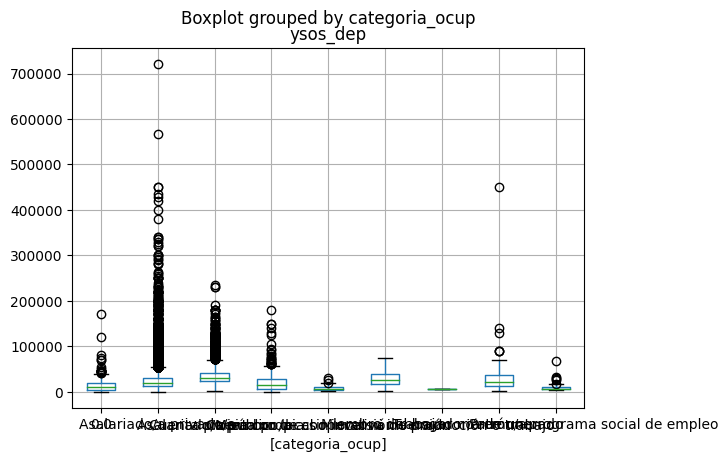

In [14]:
df_ysos.boxplot(column=['ysos_dep'], by=['categoria_ocup'])
print(df_ysos.groupby(['categoria_ocup'])['ysos_dep'].count())
print(df_ysos.groupby(['categoria_ocup'])['ysos_dep'].count() / len(df_ysos))

In [15]:
df_ysos = df_ysos.loc[(df_ysos['categoria_ocup'] == "Asalariado/a privado/a") | (df_ysos['categoria_ocup'] == "Asalariado/a público/a")]

In [16]:
df_ysos['categoria_ocup'].head()

0    Asalariado/a privado/a
2    Asalariado/a público/a
5    Asalariado/a privado/a
7    Asalariado/a privado/a
8    Asalariado/a privado/a
Name: categoria_ocup, dtype: category
Categories (9, object): [0.0, 'Asalariado/a privado/a', 'Asalariado/a público/a', 'Cuenta propia con local o inversión', ..., 'Miembro de cooperativa de producción o trabajo', 'Miembro del hogar no remunerado', 'Patrón/a', 'Trabajador/a de un programa social de empleo']

# Análisis estadístico descriptivo y transformaciones de variables

* Estructura del dataset

In [17]:
df_ysos.head()

,ysos_dep,edad,sexo,anios_educ,antiguedad,categoria_ocup
0,18000.0,70.0,Hombre,6.0,7.0,Asalariado/a privado/a
2,48000.0,52.0,Hombre,6.0,32.0,Asalariado/a público/a
5,33000.0,42.0,Mujer,16.0,0.0,Asalariado/a privado/a
7,2400.0,29.0,Mujer,8.0,1.0,Asalariado/a privado/a
8,23000.0,37.0,Hombre,6.0,4.0,Asalariado/a privado/a


In [18]:
df_ysos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37385 entries, 0 to 118262
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ysos_dep        37385 non-null  float64 
 1   edad            37385 non-null  float64 
 2   sexo            37385 non-null  category
 3   anios_educ      37385 non-null  float64 
 4   antiguedad      37385 non-null  float64 
 5   categoria_ocup  37385 non-null  category
dtypes: category(2), float64(4)
memory usage: 1.5 MB


In [19]:
df_ysos.describe()

,ysos_dep,edad,anios_educ,antiguedad
count,37385.000000,37385.000000,37385.000000,37385.000000
mean,27318.851892,40.441648,11.556079,8.576327
std,23157.617331,12.898233,4.599975,9.605859
min,43.000000,14.000000,0.000000,0.000000
25%,15000.000000,30.000000,8.000000,2.000000
50%,22000.000000,40.000000,11.000000,5.000000
75%,33000.000000,51.000000,15.000000,12.000000
max,720000.000000,91.000000,36.000000,60.000000


In [20]:
pd.isnull(df_ysos).describe()

,ysos_dep,edad,sexo,anios_educ,antiguedad,categoria_ocup
count,37385,37385,37385,37385,37385,37385
unique,1,1,1,1,1,1
top,False,False,False,False,False,False
freq,37385,37385,37385,37385,37385,37385


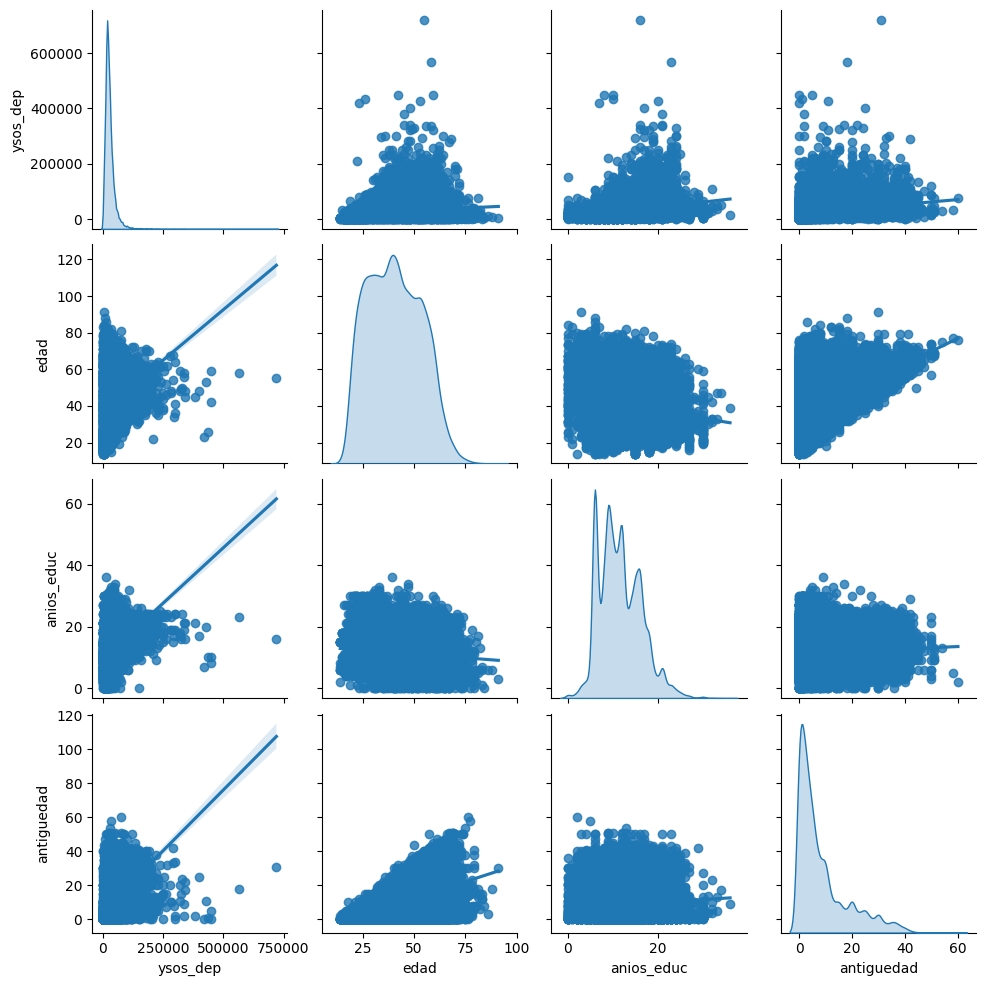

In [21]:
sns.pairplot(df_ysos, kind="reg", diag_kind="kde")

* Principales características de la variable de respuesta
    - Análisis gráfico de normalidad; opción por la transformación logarítmica

**Tarea 2.1:** Investigar que presentan las gráficas _qqplot_ y que conclusiones
permite extraer acerca de la normalidad de la variable.

Las gráficas del tipo QQPlot (_Quantile-Quantile plot_) son representaciones que
permiten comparar gráficamente dos distribuciones de datos. Comunmente se utilizan
para comparar la distribución de datos observados o presentes en un _dataset_ respecto
de una distribución teórica, generalmente la distribución normal.

Se representan los cuantiles de los datos ordenados en el eje de las abcisas, y
los cuantiles de la distribución teórica candidata en el eje de las ordenadas. Si
la conjunción de ambas coordenadas resulta en puntos alineados sobre la diagonal
del gráfico, es posible concluir que los datos se ajustan a la distribución
seleccionada. Así, cuanto más se desvíen los puntos, peor será el ajuste y más
diferentes las distribuciones.

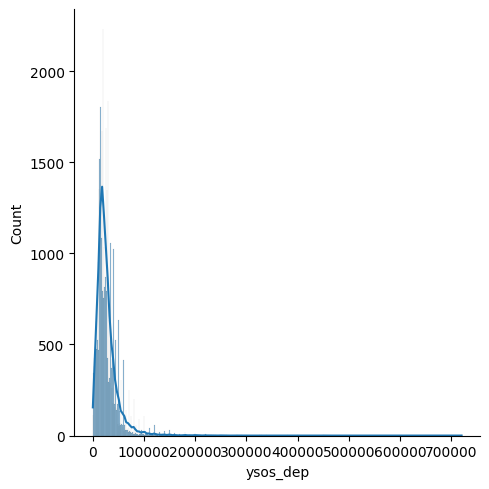

In [22]:
sns.displot(df_ysos['ysos_dep'], kde = True)

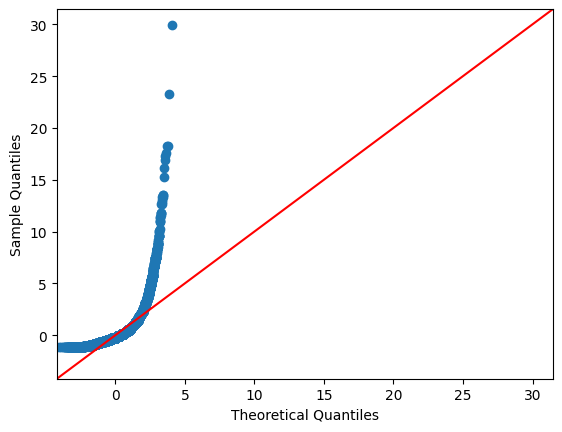

In [23]:
sm.qqplot(np.array(df_ysos['ysos_dep']), line='45', fit=True);

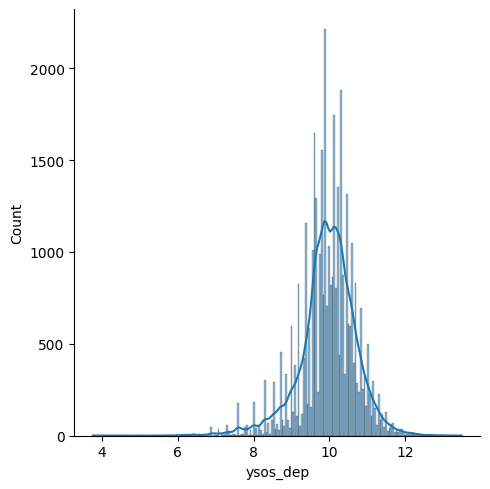

In [24]:
sns.displot(np.log(df_ysos['ysos_dep']), kde = True)

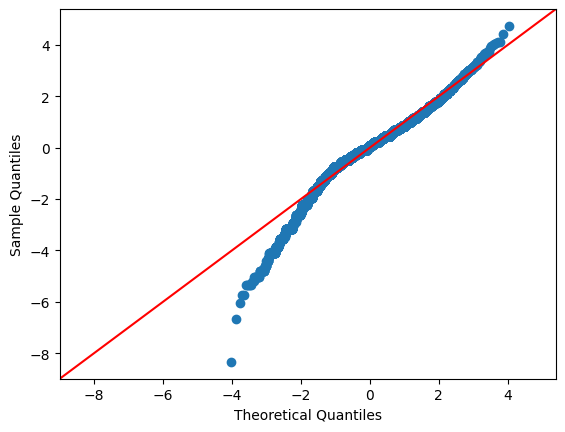

In [25]:
sm.qqplot(np.array(np.log(df_ysos['ysos_dep'])), line='45', fit=True); #punto y coma evita duplicación del gráfico

* Algunas ventajas de la transformación logarítmica
    - Si en nuestro análisis asumimos normalidad de la variable de respuesta, la transformación favorece su cumplimiento
    - Ayuda al cumplimiento del supuesto de varianza constante
* Desventajas de la transformación logarítmica
    - Dificulta la interpretación    
* Defino variable de respuesta transformada y descarto variable original (defino nuevo dataset df_l_ysos)

In [26]:
df_ysos['l_ysos_dep'] = np.log(df_ysos['ysos_dep'])
df_l_ysos = df_ysos.drop(columns=['ysos_dep'])
df_l_ysos.head()

,edad,sexo,anios_educ,antiguedad,categoria_ocup,l_ysos_dep
0,70.0,Hombre,6.0,7.0,Asalariado/a privado/a,9.798127
2,52.0,Hombre,6.0,32.0,Asalariado/a público/a,10.778956
5,42.0,Mujer,16.0,0.0,Asalariado/a privado/a,10.404263
7,29.0,Mujer,8.0,1.0,Asalariado/a privado/a,7.783224
8,37.0,Hombre,6.0,4.0,Asalariado/a privado/a,10.043249


* Comportamiento de la variable de respuesta con respecto a las variables predictoras

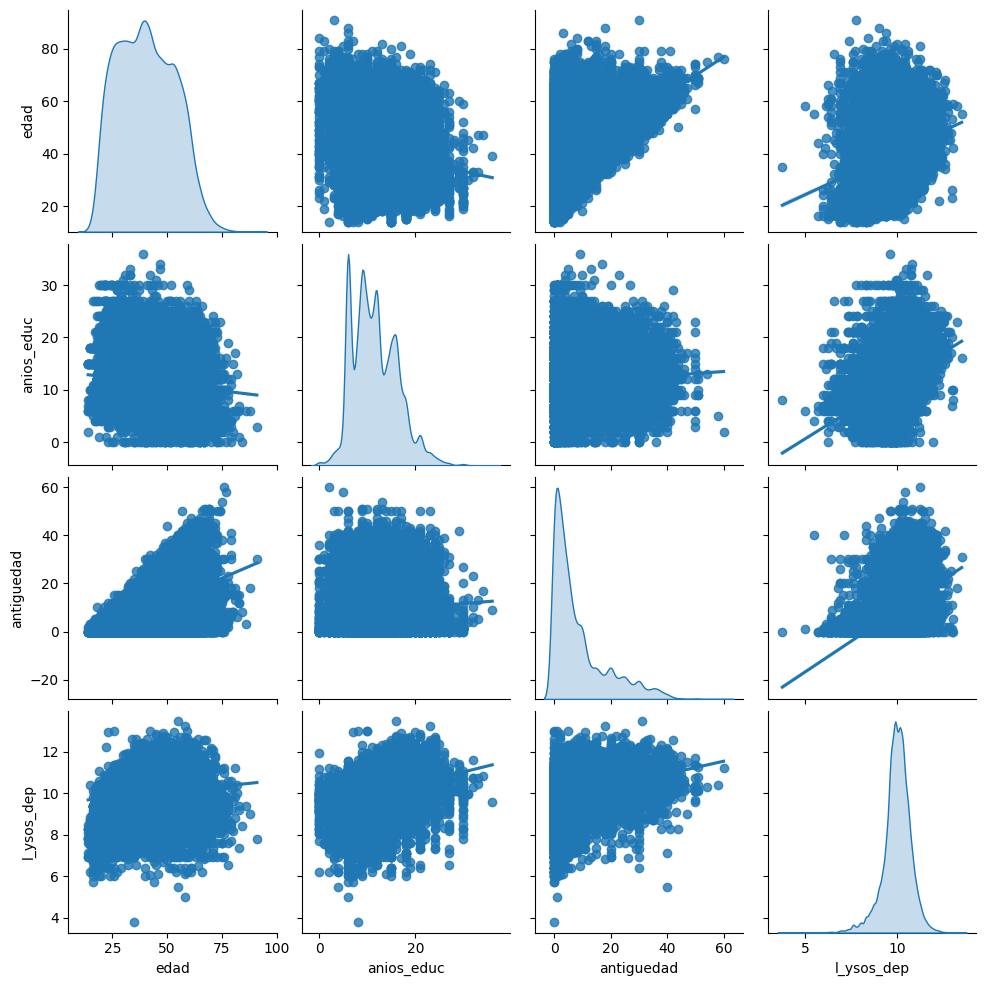

In [27]:
sns.pairplot(df_l_ysos, kind="reg", diag_kind="kde")

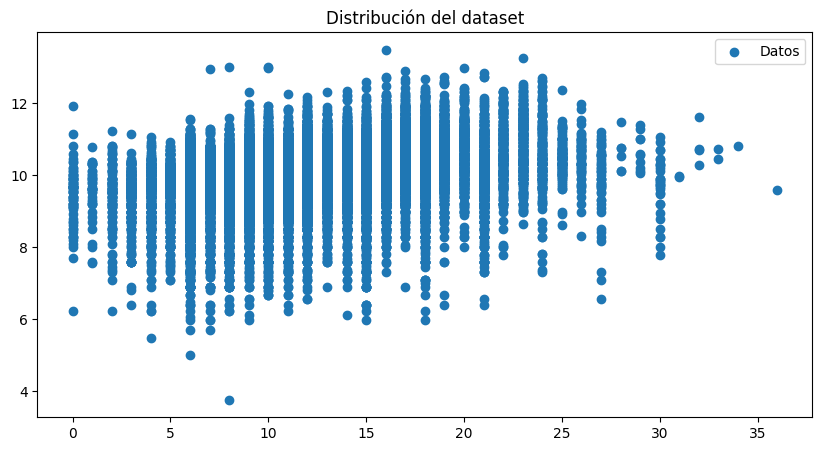

In [28]:
plt.figure(figsize=(10,5))
plt.scatter(df_l_ysos['anios_educ'], df_ysos['l_ysos_dep'], label='Datos')
plt.title('Distribución del dataset')
plt.legend()

<Axes: title={'center': 'l_ysos_dep'}, xlabel='[anios_educ]'>

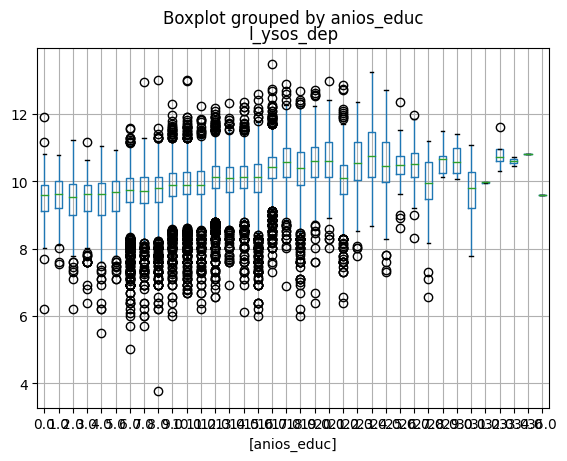

In [29]:
df_l_ysos.boxplot(column='l_ysos_dep', by=['anios_educ'])

<Axes: title={'center': 'l_ysos_dep'}, xlabel='[categoria_ocup]'>

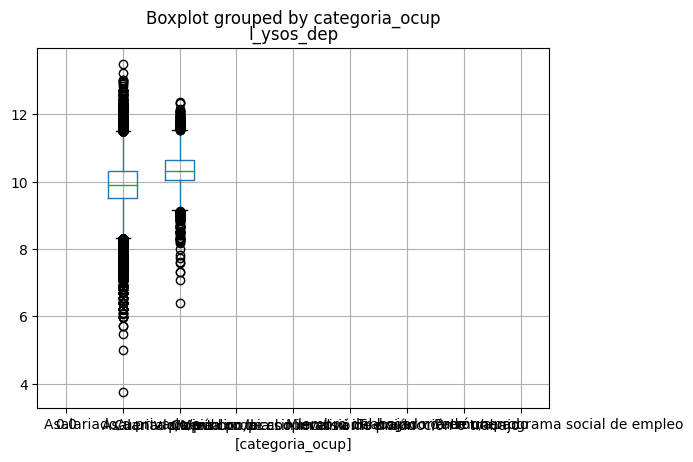

In [30]:
df_l_ysos.boxplot(column=['l_ysos_dep'], by=['categoria_ocup'])

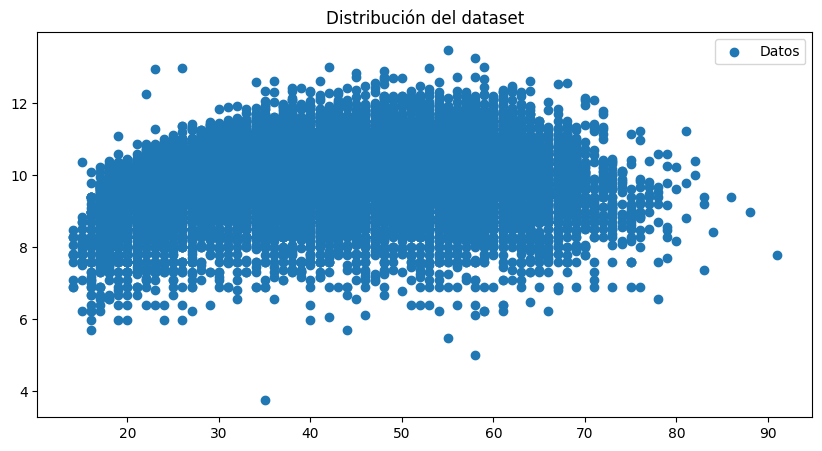

In [31]:
plt.figure(figsize=(10,5))
plt.scatter(df_l_ysos['edad'], df_l_ysos['l_ysos_dep'], label='Datos')
plt.title('Distribución del dataset')
plt.legend()

**Tarea 2.2:** Completar AED de variables predictoras, en particular sobre la
correlación entre variables predictoras (buscar métodos gráficos para ello),
y sus consecuencias en la implementación de regresión.

Determinar si las columnas en el _dataset_ se encuentran correlacionadas,
resulta un dato valioso a considerar al momento de determinar que variables
utilizar en el entrenamiento del modelo.

Columnas altamente correlacionadas con la variable objetivo a predecirse, serán
las que más expliquen su comportamiento y las que más valor aporten en el
entrenamiento. Por otro lado, un alto correlacionamiento entre variables predictoras
implicaría que estas se encuentran vinculadas en cuanto a su variación, por tanto
ofreciendo la presencia de ambas limitada información adicional en el proceso de
entrenamiento, frente a si se utilizara una sola. Ambos escenarios brindan matices
que pueden llegar a influenciar la selección de columnas realizadas a incluir
en el entrenamiento.

En este caso en particular, es posible obtener el correlacionamiento entre
variables numéricamente como:

In [32]:
correlation_matrix = df_l_ysos[["edad", "anios_educ", "antiguedad", "l_ysos_dep"]].corr()
display(correlation_matrix)

,edad,anios_educ,antiguedad,l_ysos_dep
edad,1.000000,-0.140901,0.527733,0.187590
anios_educ,-0.140901,1.000000,0.079086,0.354763
antiguedad,0.527733,0.079086,1.000000,0.395731
l_ysos_dep,0.187590,0.354763,0.395731,1.000000


Estos resultados se encuentran en el intervalo `[-1, 1]`. Cuanto más cercanos a
`-1` mejor se correlacionan inversamente las variables (es decir, que cuando una
tiende a disminuir la otra tiende a aumentar), y cuanto más cercano a `1`, mejor
es la correlación directa.

Es decir, cuanto mayor el resultado obtenido en valor absoluto, más están
correlacionadas las variables. El valor máximo obtenido en el caso superior es
entre las columnas `edad` y `antiguedad`, lo cual, intuitivamente, parece tener
sentido. El menor entre `antiguedad` y `anios_educ`.

Gráficamente, es posible visualizar lo anterior utilizando una gráfica del tipo
`heatmap`, de la situiente forma (cuanto más cálido el cuadrante más,
correlacionadas las variables):

* Transformación de variables predictoras numéricas
    - **Tarea 2.3:** Investigar que es y bajo que condiciones conviene realizar
la estandarización de variables numéricas en el contexto de regresión

El término "estandarización" coreresponde a un proceso de transformación de
variables que es posible aplicar previo al entrenamiento de un modelo de
aprendizaje automático. Consiste en transformar variables de forma tal de
llevarlas a un intervalo de cotas conocidas: uno habitual es el intervalo
cerrado `[-1, 1]` (con media 0 y desviación estándar 1).

Existen varias trasnsformaciones que llevarían variables a ese intervalo, una
forma típica es tomar cada variable, restarle su media y dividir el resultado
entre la desviación estándar.

Las razones para aplicar esta transformación en el contexto de regresión pasan
por que, en primer lugar, algunos algoritmos (como la regresión lineal) son
sensibles a diferencias de escala entre variables, para _datasets_ con columnas
que manejen rangos muy distintos. Así, simplemente por los valores concretos que
manejan, el modelo puede tender a favorecer a variables con valores más altos,
por ejemplo, lo cual puede no favorecer al resultado del aprendizaje. Al
estandarizar, se llevarían al mismo intervalo `[-1, 1]` y se evitaría este
problema.

Por otro lado, otro factor a considerar es que cuando se utiliza regularización,
como `ridge` o `lasso`, la utilización de variables no estandarizadas puede
afectar los resultados finales obtenidos. Dado que estos métodos penalizan a
modelos complejos respecto del _loss_ obtenido en función de la magnitud de 
sus coeficientes o pesos, de entrenarse sin estandarizar variables estos podrían
tomar valores que penalicen injustamente al modelo (puesto que los coeficientes
tenderían a verse afectados por las diferencias entre escalas), y por tanto
sesgar los resultados.

* Transformación de variables predictoras categóricas: _One-Hot Encoding_ neceasario para implementar regresión
    - Se debe hacer sobre el _dataframe_ antes de la partición en _train_ y _test_, porque cambia los índices (`X`, `y` quedarían con índ. distintos)

In [33]:
categorical_columns = ['sexo', 'categoria_ocup']
numerical_columns = ['edad', 'anios_educ', 'antiguedad']

column_transform = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categorical_columns), # Cuando son dos categorías, elimina una
    (StandardScaler(), numerical_columns),
    remainder='passthrough', # Deja el resto de las columnas sin transformar
    verbose_feature_names_out=False)

In [34]:
df_l_ysos_transf = pd.DataFrame(
    column_transform.fit_transform(df_l_ysos), 
    columns=column_transform.get_feature_names_out()
)

df_l_ysos_transf.head()

,sexo_Mujer,categoria_ocup_Asalariado/a público/a,edad,anios_educ,antiguedad,l_ysos_dep
0,0.0,0.0,2.291690,-1.207866,-0.164103,9.798127
1,0.0,1.0,0.896131,-1.207866,2.438510,10.778956
2,1.0,0.0,0.120821,0.966088,-0.892834,10.404263
3,1.0,0.0,-0.887083,-0.773075,-0.788730,7.783224
4,0.0,0.0,-0.266835,-1.207866,-0.476416,10.043249


## Partición del dataset: Train y Test

En un escenario del mundo real, no sabríamos la relación entre los predictores y el resultado. Dado un conjunto de datos, nuestra tarea es encontrar modelos candidatos adecuados y elegir el que mejor se adapte a nuestra información.

Con este fin, dividimos nuestros datos en, al menos, dos conjuntos distintos:
- Conjunto de entrenamiento (`train`): la porción de datos que se ajusta al modelo.
- Conjunto de pruebas (`test`): la parte de datos para evaluar el rendimiento del modelo.
    
**Como el conjunto de prueba contiene datos no vistos antes por el modelo, la evaluación de los rendimientos en ese conjunto proporciona una mejor estimación de cómo funcionaría el modelo en datos no vistos del mundo real.**


Para la división de nuestro dataset utilizaremos la librería: `sklearn.model_selection.train_test_split()` cuyos parámetros son:
   - `arrays`: Secuencia de indexables. Las listas, las matrices numpy, las matrices scipy-sparse y los marcos de datos de pandas son entradas válidas.
   - `test_size`: `int` o `float`, por defecto `None`. Si es flotante, debe estar entre `0.0` y `1.0` y representar el porcentaje del conjunto de datos para probar la división. Si se usa `int`, se refiere al número total de muestras de prueba. Si el valor es `None`, se utiliza el complemento del tamaño del `train`. Se establecerá en `0.25` si el tamaño del `train` también es `None`.
   - `train_size`: `int` o `float`, por defecto `None`
   - `random_state`: `int`, por defecto `None`. Controla cómo se mezclan los datos antes de implementar la división. Para una salida repetible en varias llamadas a funciones, pasar un `int`.
   - `shuffle`: objeto booleano, por defecto `True`. Si los datos se deben mezclar o no antes de dividirlos. Estratificar debe ser `None` si `shuffle == False`.
   - `stratify`: objeto tipo matriz, por defecto es `None`. Si se recibe `None`, los datos se estratifican usándolos como etiquetas de clase.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df_l_ysos_transf[['edad', 'sexo_Mujer', 'anios_educ', 'antiguedad', 'categoria_ocup_Asalariado/a público/a']],
    df_l_ysos_transf['l_ysos_dep'], 
    test_size=0.20, 
    random_state=1234
)

In [36]:
X_train

,edad,sexo_Mujer,anios_educ,antiguedad,categoria_ocup_Asalariado/a público/a
18823,1.593910,0.0,-0.338284,0.356420,1.0
24775,-1.042145,1.0,-0.338284,-0.684625,0.0
5417,-1.042145,0.0,0.748693,-0.684625,0.0
582,1.516379,0.0,0.748693,-0.580521,0.0
23025,0.120821,1.0,0.748693,-0.268207,0.0
...,...,...,...,...,...
32399,0.430945,0.0,-1.207866,-0.892834,0.0
17048,-0.887083,1.0,-0.120889,-0.684625,0.0
23924,0.586007,1.0,0.096506,1.189256,0.0
34086,-0.654490,0.0,-0.555680,-0.580521,0.0


In [37]:
X_test

,edad,sexo_Mujer,anios_educ,antiguedad,categoria_ocup_Asalariado/a público/a
7324,-1.274738,0.0,2.053065,-0.580521,0.0
14262,0.120821,1.0,-0.555680,0.044106,0.0
12308,1.283786,1.0,1.183484,-0.684625,1.0
26097,0.430945,1.0,-0.555680,-0.892834,0.0
35889,1.051193,1.0,0.096506,2.959033,1.0
...,...,...,...,...,...
6210,1.593910,1.0,-1.207866,-0.892834,0.0
32102,0.198352,1.0,-1.642657,-0.372312,0.0
28894,-0.266835,1.0,1.183484,-0.788730,0.0
33344,1.826504,0.0,0.748693,2.542615,1.0


## Regresión Lineal

In [38]:
reg = linear_model.LinearRegression()

### Modelo 1

Modelo lineal simple: una sola variable independiente. Utilizamos double bracket para mantener estructura de _datafram_ (`sklearn` sólo acepta objetos de 2D en train; un sólo paréntesis recto devuelve un objeto `Series`, dos paréntesis rectos devuelven un `DataFrame`).

In [39]:
print(type(X_train['anios_educ']))
print(type(X_train[['anios_educ']]))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [40]:
mod1_X_train = X_train[['anios_educ']]
mod1_X_test = X_test[['anios_educ']]

mod1 = reg.fit(mod1_X_train, y_train)

* Interpretación de los coeficientes

In [41]:
print(f'Coefficients: {mod1.coef_}')
print(f'Intercept: {mod1.intercept_ }\n')

print('Cuando solamente la variable de respuesta fue transformada mediante el',
      'logaritmo, el coeficiente beta se interpreta como una variación de',
      f'{np.around((np.exp(mod1.coef_)-1)*100, 2)[0]}% de la variable de respuesta',
      'por cada unidad de variación de la variable independiente')

Coefficients: [0.26505224]
Intercept: 9.964538712016756

Cuando solamente la variable de respuesta fue transformada mediante el logaritmo, el coeficiente beta se interpreta como una variación de 30.35% de la variable de respuesta por cada unidad de variación de la variable independiente


In [42]:
# Coefficient of determination (R2)
print(f'Score: {mod1.score(mod1_X_test, y_test)}')

Score: 0.12329451470261588


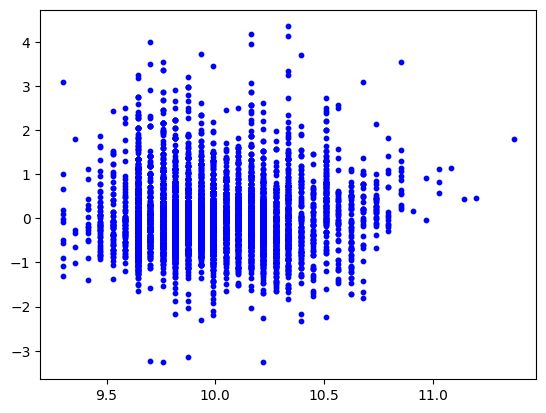

In [43]:
plt.scatter(mod1.predict(mod1_X_test), mod1.predict(mod1_X_test) - y_test,
            color = "blue", s = 10, label = 'Test data')

In [44]:
mod1_y_test_pred = mod1.predict(mod1_X_test)
mod1_mse_test = mean_squared_error(y_test, mod1_y_test_pred)
print(f'MSE train: {mean_squared_error(y_train, mod1.predict(mod1_X_train))}')
print(f'MSE test: {mean_squared_error(y_test, mod1_y_test_pred)}')


MSE train: 0.4840089924851105
MSE test: 0.4834283901748652


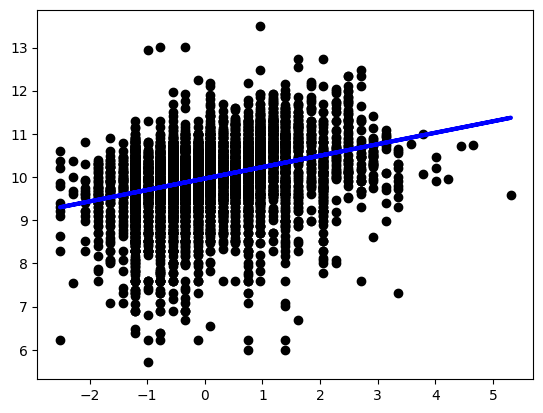

In [45]:
plt.scatter(mod1_X_test, y_test, color="black")
plt.plot(mod1_X_test, mod1_y_test_pred, color="blue", linewidth=3)

### Modelo 2

Regresión polinómica (generalización del modelo lineal simple). Utilizamos una
función _ad-hoc_ para crear el polinomio, descartando el intercepto
(columna de valor 1), ya que lo trae por defecto `reg.fit`. 

In [46]:
mod2_X_train = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_train[['anios_educ']])
mod2_X_test = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_test[['anios_educ']])

mod2 = reg.fit(mod2_X_train, y_train)

In [47]:
print(f'Coefficients: {mod2.coef_}')
print(f'Intercept: {mod2.intercept_}')

Coefficients: [ 0.28579813 -0.03746504]
Intercept: 10.002023263807821


In [48]:
# Coefficient of determination (R2)
print(mod2.score(mod2_X_test, y_test))

print(f'MSE train: {mean_squared_error(y_train, mod2.predict(mod2_X_train))}')
print(f'MSE test: {mean_squared_error(y_test, mod2.predict(mod2_X_test))}')

0.12662130652113834
MSE train: 0.48144452821673117
MSE test: 0.48159394789037363


* **Tarea 2.4**: Realizar al menos tres derivaciones del modelo 2 (_2.a_, _2.b_, _2.c_) cada una con mayor grado en el polinomio. Analizar los resultados y conclusiones, considerando particularmente la evidencia acerca del problema del sobreajuste.

In [49]:
def test_linear_regression_with(degree: int):
    mod_X_train = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X_train[['anios_educ']])
    mod_X_test = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X_test[['anios_educ']])
    mod = reg.fit(mod_X_train, y_train)

    print(f'Coefficients: {mod.coef_}')
    print(f'Intercept: {mod.intercept_}\n')
    print(f'Score: {mod.score(mod_X_test, y_test)}')

    print(f'MSE train: {mean_squared_error(y_train, mod.predict(mod_X_train))}')
    print(f'MSE test: {mean_squared_error(y_test, mod.predict(mod_X_test))}')

#### Modelo 2.a

In [50]:
test_linear_regression_with(degree=5)

Coefficients: [ 0.3379813   0.00233803 -0.02563185 -0.00240118  0.0009169 ]
Intercept: 9.979398081109132

Score: 0.1302435738782134
MSE train: 0.47938580357076693
MSE test: 0.4795965760174011


#### Modelo 2.b

In [51]:
test_linear_regression_with(degree=15)

Coefficients: [ 1.37706553e-01 -4.74599885e-01  5.47558097e-01  9.34193230e-01
 -5.89151167e-01 -6.00803108e-01  3.20070280e-01  1.52199219e-01
 -9.15087856e-02 -1.16914914e-02  1.24520635e-02 -9.45841977e-04
 -5.79410012e-04  1.30885204e-04 -8.18034807e-06]
Intercept: 10.005316063932346

Score: -17.91956850266322
MSE train: 0.47562864051990306
MSE test: 10.432530305137874


In [52]:
test_linear_regression_with(degree=30)

Coefficients: [ 6.37321501e-08  1.85362236e-08 -1.12734577e-08 -2.39688101e-08
 -2.35456823e-08 -8.16852418e-08 -6.16336079e-08 -2.57231178e-07
 -1.65962115e-07 -7.33329319e-07 -3.71921204e-07 -1.79324846e-06
 -4.33760702e-07 -3.41204831e-06  1.01990562e-06 -4.25444265e-06
  6.30999436e-06 -3.23491591e-06  1.01411905e-05 -6.20860076e-06
 -3.48503511e-06  3.74083476e-06 -3.77615428e-07 -5.37938344e-07
  1.94707717e-07 -1.17683665e-09 -1.25814835e-08  3.04847056e-09
 -3.09496431e-10  1.20949770e-11]
Intercept: 9.95449686206935

Score: -138935332.00706655
MSE train: 0.5415289736444492
MSE test: 76611000.50176154


En estos resultados vemos que, si bien el error en _train_ presenta muy leves
cambios entre los distintos casos, a medida de que el grado del polinomio crece,
el _score_ logrado disminuye, y el error en _train_ aumenta significativamente.
Esto es un indicador de sobreajuste: si bien el modelo logra predecir
correctamente los datos de entrenamiento, tiene poca capacidad de generalización:
su _performance_ sobre datos nuevos, o desconocidos, es mala.

Por tanto, parecería ser conveniente utilizar un polinomio de grado reducido,
puesto que grados mayores acrecientan este problema de sobreajuste. El mejor
comportamiento para este caso parece obtenerse con un polinomio de grado 5.

### Modelo 3

                            OLS Regression Results                            
Dep. Variable:             l_ysos_dep   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     2969.
Date:                Sun, 16 Jul 2023   Prob (F-statistic):               0.00
Time:                        18:51:25   Log-Likelihood:                -27581.
No. Observations:               29908   AIC:                         5.517e+04
Df Residuals:                   29902   BIC:                         5.522e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

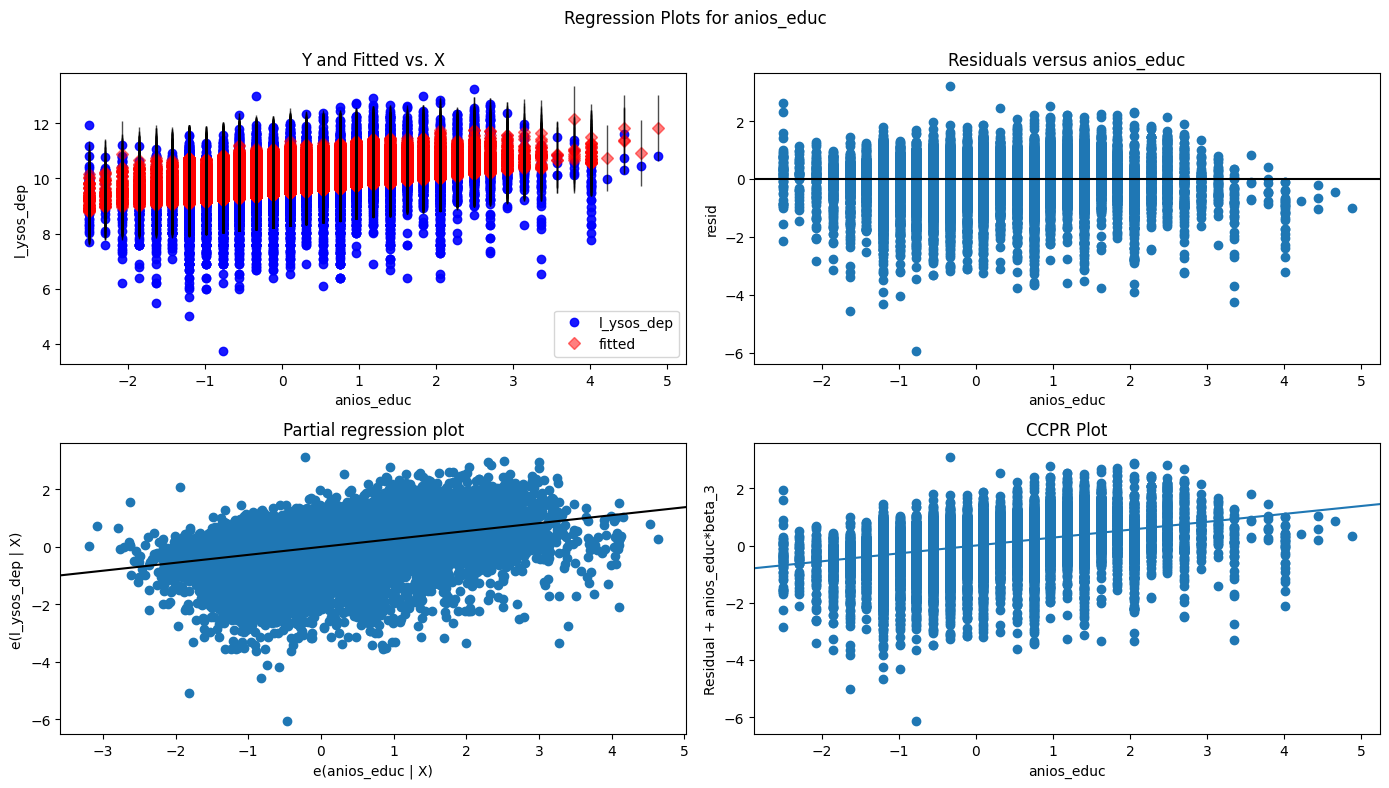

In [53]:
mod3_X_train = sm.add_constant(X_train)
mod3_X_test = sm.add_constant(X_test)

mod3 = sm.OLS(y_train, mod3_X_train).fit()

print(mod3.summary())
sm.graphics.plot_regress_exog(mod3, 'anios_educ', fig=plt.figure(figsize=(14, 8)))

In [54]:
print(f'MSE train: {mean_squared_error(y_train, mod3.predict(mod3_X_train))}')
print(f'MSE test: {mean_squared_error(y_test, mod3.predict(mod3_X_test))}')

MSE train: 0.37027606461786616
MSE test: 0.37365173529392365


* **Tarea 2.5**: Incorporar más variables. Analizar los resultados y
conclusiones, considerando particularmente la evidencia acerca del problema del
sobreajuste.

Nos piden, entonces, entrenar el modelo presentado en las celdas superiores,
mas utilizando adicionales columnas del _dataset_. Seleccionando algunas de las
que no fueron incluidas originalmente, y ejecutando nuevamente el proceso de
transformación al que fueron sometidas, la división en _train_ y _test_, y demás
fases llevadas a cabo y presentadas anteriormente, tenemos que:

In [55]:
columns_to_add = ['mto_cuota', 'mto_emer', 'mto_hogcon', 'mto_desay',
                  'mto_almue', 'mto_vacas', 'mto_oveja', 'mto_caball', 
                  'indabajo', 'indaplomo', 'indadiabet', 'indarenal',
                  'indarendia', 'indaceliac', 'pesoano', 'pesosem', 'pesotri',
                  'pesomen', 'indatuberc', 'indaoncolo', 'indasida']

for column in columns_to_add:
    df_l_ysos[column] = dfP2017[column]

df_l_ysos_transf = pd.DataFrame(
    column_transform.fit_transform(df_l_ysos), 
    columns=column_transform.get_feature_names_out()
)

df_l_ysos_transf.head()

,sexo_Mujer,categoria_ocup_Asalariado/a público/a,edad,anios_educ,antiguedad,l_ysos_dep,mto_cuota,mto_emer,mto_hogcon,mto_desay,...,indarenal,indarendia,indaceliac,pesoano,pesosem,pesotri,pesomen,indatuberc,indaoncolo,indasida
0,0.0,0.0,2.291690,-1.207866,-0.164103,9.798127,1779.0,759.0,801.0,30.0,...,689.0,689.0,689.0,29.0,59.0,120.0,340.0,585.0,585.0,585.0
1,0.0,1.0,0.896131,-1.207866,2.438510,10.778956,1836.0,576.0,866.0,32.0,...,691.0,691.0,691.0,34.0,69.0,137.0,469.0,578.0,578.0,578.0
2,1.0,0.0,0.120821,0.966088,-0.892834,10.404263,1816.0,780.0,866.0,32.0,...,688.0,688.0,688.0,26.0,51.0,101.0,301.0,585.0,585.0,585.0
3,1.0,0.0,-0.887083,-0.773075,-0.788730,7.783224,1822.0,781.0,866.0,32.0,...,698.0,698.0,698.0,38.0,76.0,153.0,451.0,580.0,580.0,580.0
4,0.0,0.0,-0.266835,-1.207866,-0.476416,10.043249,1822.0,781.0,866.0,32.0,...,698.0,698.0,698.0,38.0,76.0,153.0,451.0,580.0,580.0,580.0


                            OLS Regression Results                            
Dep. Variable:             l_ysos_dep   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     821.6
Date:                Sun, 16 Jul 2023   Prob (F-statistic):               0.00
Time:                        18:51:29   Log-Likelihood:                -27324.
No. Observations:               29908   AIC:                         5.469e+04
Df Residuals:                   29888   BIC:                         5.486e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

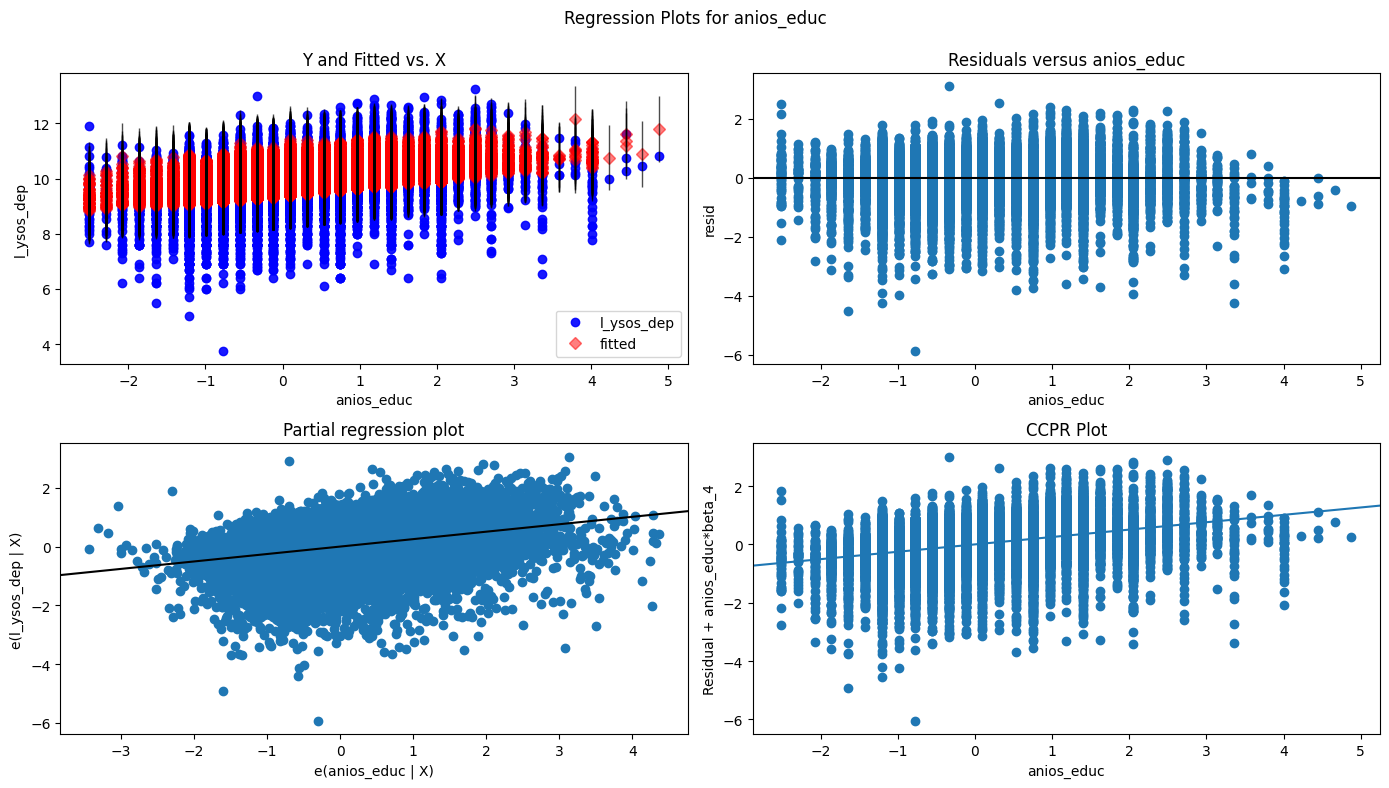

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    df_l_ysos_transf.drop('l_ysos_dep', axis=1),
    df_l_ysos_transf['l_ysos_dep'], 
    test_size=0.20, 
    random_state=1234
)

mod3_X_train = sm.add_constant(X_train)
mod3_X_test = sm.add_constant(X_test)

mod3 = sm.OLS(y_train, mod3_X_train).fit()

print(mod3.summary())
sm.graphics.plot_regress_exog(mod3, 'anios_educ', fig=plt.figure(figsize=(14, 8)))

In [57]:
print(f'MSE train: {mean_squared_error(y_train, mod3.predict(mod3_X_train))}')
print(f'MSE test: {mean_squared_error(y_test, mod3.predict(mod3_X_test))}')

MSE train: 0.36398523706530067
MSE test: 0.3692224542690956


Comparando estos resultados con los obtenidos para el modelo utilizando el
número de columnas original, podemos ver que el valor obtenido para ambos
errores de _train_ y _test_ se ha reducido. Esto parece indicar una mejora de
_performance_ neta, sin haber caído aún en el sobreajuste, pues el error en
_test_ también disminuye. Si bien se hicieron varias pruebas con distinto
número de columnas, ello siguió ocurriendo. Esto parece indicar, por tanto, que
aún existen oportunidades de mejora del modelo obtenido, pudiéndose continuar
agregando aún más columnas o aplicándose nuevas transformaciones de datos a fin
de seguir refinando el modelo obtenido.